# Stroke Prediction v4 - Pipeline de Producao

In [55]:
# === 1. CONFIGURACAO ===
from pathlib import Path
import sys

sys.path.insert(0, str(Path('.').resolve() / 'src'))

from src import (
    load_and_validate_data, engineer_medical_features,
    create_preprocessing_pipeline, train_model_suite,
    evaluate_model_comprehensive, analyze_fairness,
    monitor_drift, save_model_with_metadata
)
from src.calibration import calibrate_model_comprehensive, plot_calibration_curve
from src.evaluation import summarize_threshold_performance, summarize_threshold_grid
from src.clinical_utility import decision_curve_analysis, plot_decision_curve
from src.visualization import (
    plot_model_comparison_comprehensive,
    plot_calibration_analysis,
    plot_confusion_matrices
)

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

print('Ambiente carregado com sucesso')
print(f"Diretorio de trabalho: {Path('.').resolve()}")


Ambiente carregado com sucesso
Diretorio de trabalho: C:\Users\argus.portal\workspace\StrokePrediction


In [56]:
# === 2. CARREGAMENTO E VALIDACAO ===
df, metadata = load_and_validate_data()

print('Informacoes do conjunto:')
print(f"   Formato: {metadata['shape']}")
print(f"   Prevalencia: {metadata['prevalence']:.3%}")
print(f"   Checksum: {metadata['checksum']}")

df.head()


Informacoes do conjunto:
   Formato: (5110, 12)
   Prevalencia: 4.873%
   Checksum: 67af8a28995a9b64


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [57]:
# === 3. FEATURE ENGINEERING ===
df_enhanced = engineer_medical_features(df)

novas = [c for c in df_enhanced.columns if c not in df.columns]
print(f"Foram geradas {len(novas)} novas variaveis")

df_enhanced.head()


Foram geradas 20 novas variaveis


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,...,glucose_age_risk,smoking_status_clean,smoking_risk,is_smoker,gender_clean,gender_risk,high_stress_job,total_risk_score,age_hypertension_int,metabolic_syndrome
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,...,15.32223,formerly smoked,1,0,Male,1,1,11,0.0,1
1,Female,61.0,0,0,Yes,Private,Rural,202.21,28.1,never smoked,...,12.33481,never smoked,0,0,Female,0,1,2,0.0,0
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,...,8.47360,never smoked,0,0,Male,1,1,8,0.0,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,...,8.39027,smokes,2,1,Female,0,1,5,0.0,1
4,Female,79.0,1,0,Yes,Private,Rural,174.12,24.0,never smoked,...,13.75548,never smoked,0,0,Female,0,1,7,79.0,0


📊 DISTRIBUICAO DO TARGET:
stroke
0    0.951272
1    0.048728
Name: proportion, dtype: float64
📈 VALORES AUSENTES:
Series([], dtype: int64)
🔗 MAIORES CORRELACOES COM O TARGET:
stroke                  1.000000
age_squared             0.274620
cardio_risk_score       0.266467
is_elderly              0.247136
total_risk_score        0.246581
glucose_age_risk        0.246558
age                     0.245257
bmi_age_interaction     0.212057
age_hypertension_int    0.149634
heart_disease           0.134914
dtype: float64


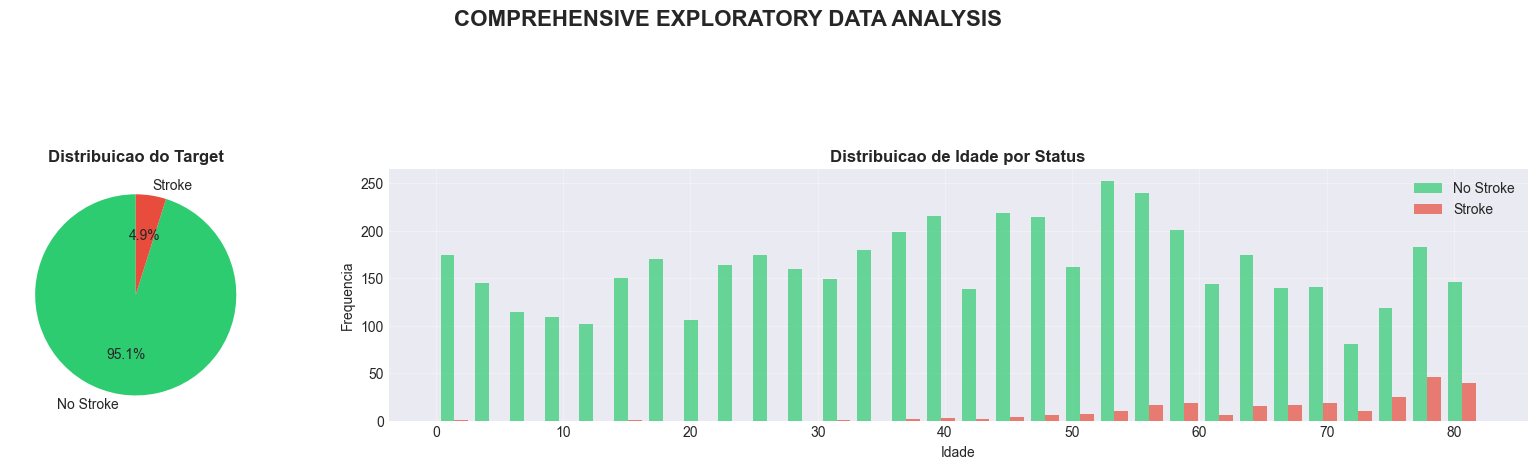

📋 ESTATISTICAS RESUMO POR STATUS:


age               avg_glucose_level                   bmi        \
         mean    std median              mean    std  median   mean   std   
stroke                                                                      
0       41.97  22.29   43.0            104.80  43.85   91.47  28.80  7.78   
1       67.73  12.73   71.0            132.54  61.92  105.22  30.09  5.86   

               
       median  
stroke         
0        28.1  
1        28.1

C:\Users\argus.portal\AppData\Local\Temp\ipykernel_58492\1136014854.py:103: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\argus.portal\workspace\StrokePrediction\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


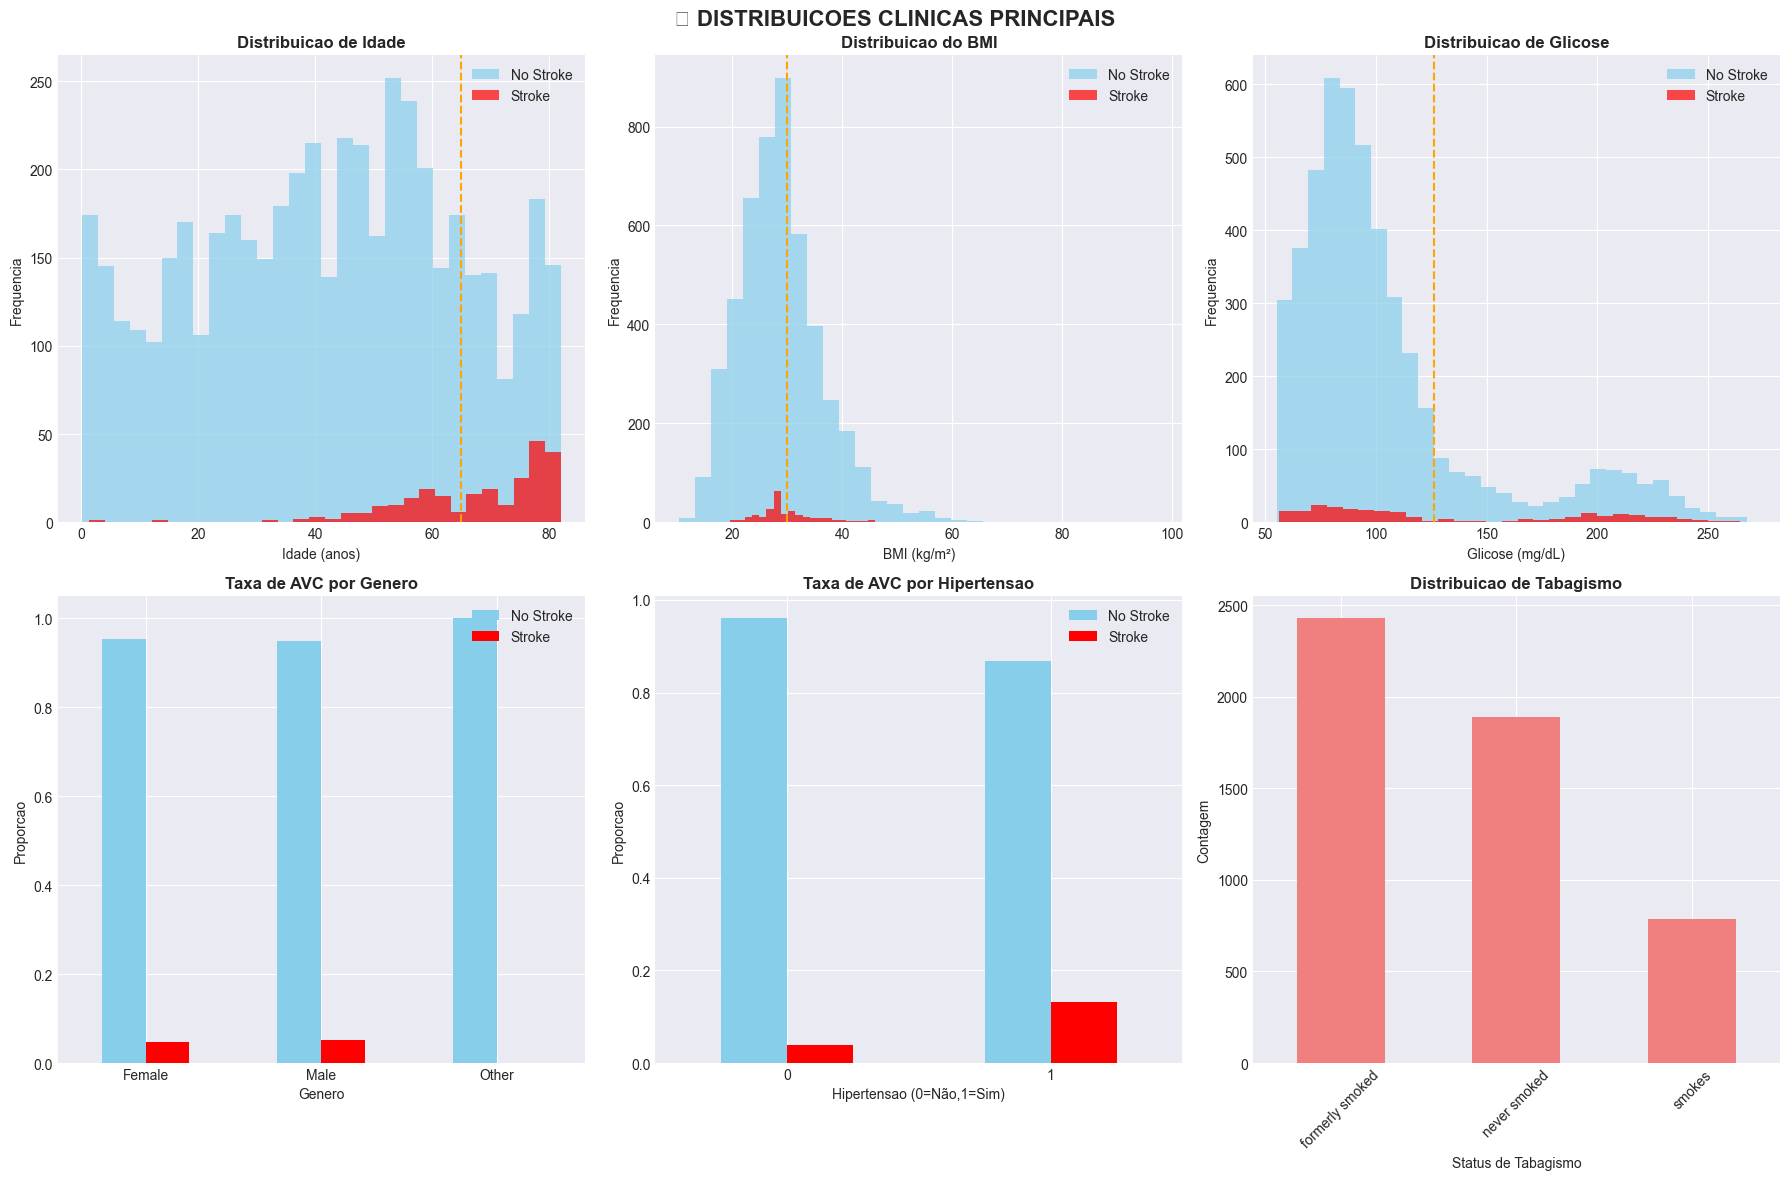

C:\Users\argus.portal\AppData\Local\Temp\ipykernel_58492\1136014854.py:115: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\argus.portal\workspace\StrokePrediction\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


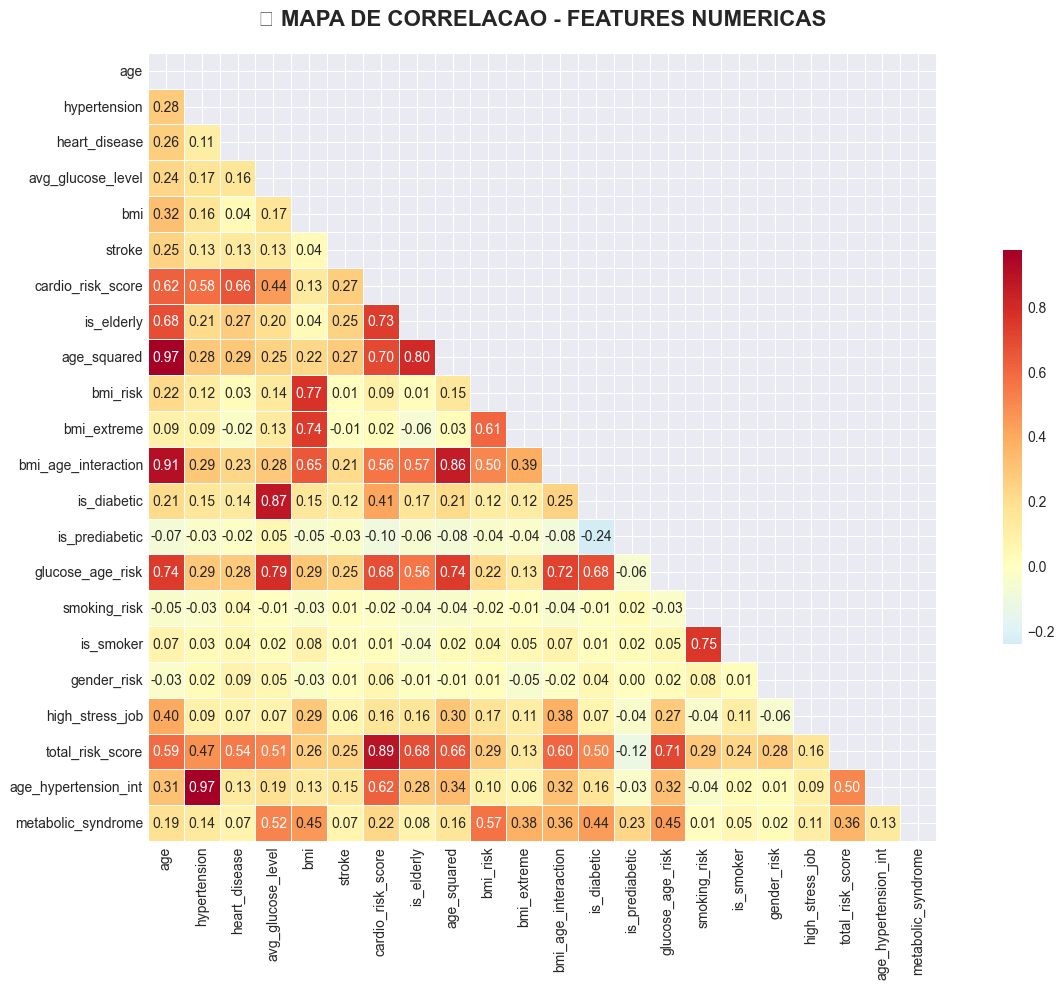

C:\Users\argus.portal\AppData\Local\Temp\ipykernel_58492\1136014854.py:143: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stroke_risk = df_temp.groupby('risk_bin')[target].agg(['count', 'mean'])
C:\Users\argus.portal\AppData\Local\Temp\ipykernel_58492\1136014854.py:143: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stroke_risk = df_temp.groupby('risk_bin')[target].agg(['count', 'mean'])
C:\Users\argus.portal\AppData\Local\Temp\ipykernel_58492\1136014854.py:189: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout(rect=(0, 0.04, 1, 0.96))
C:\Users\argus.portal\AppData\Local\

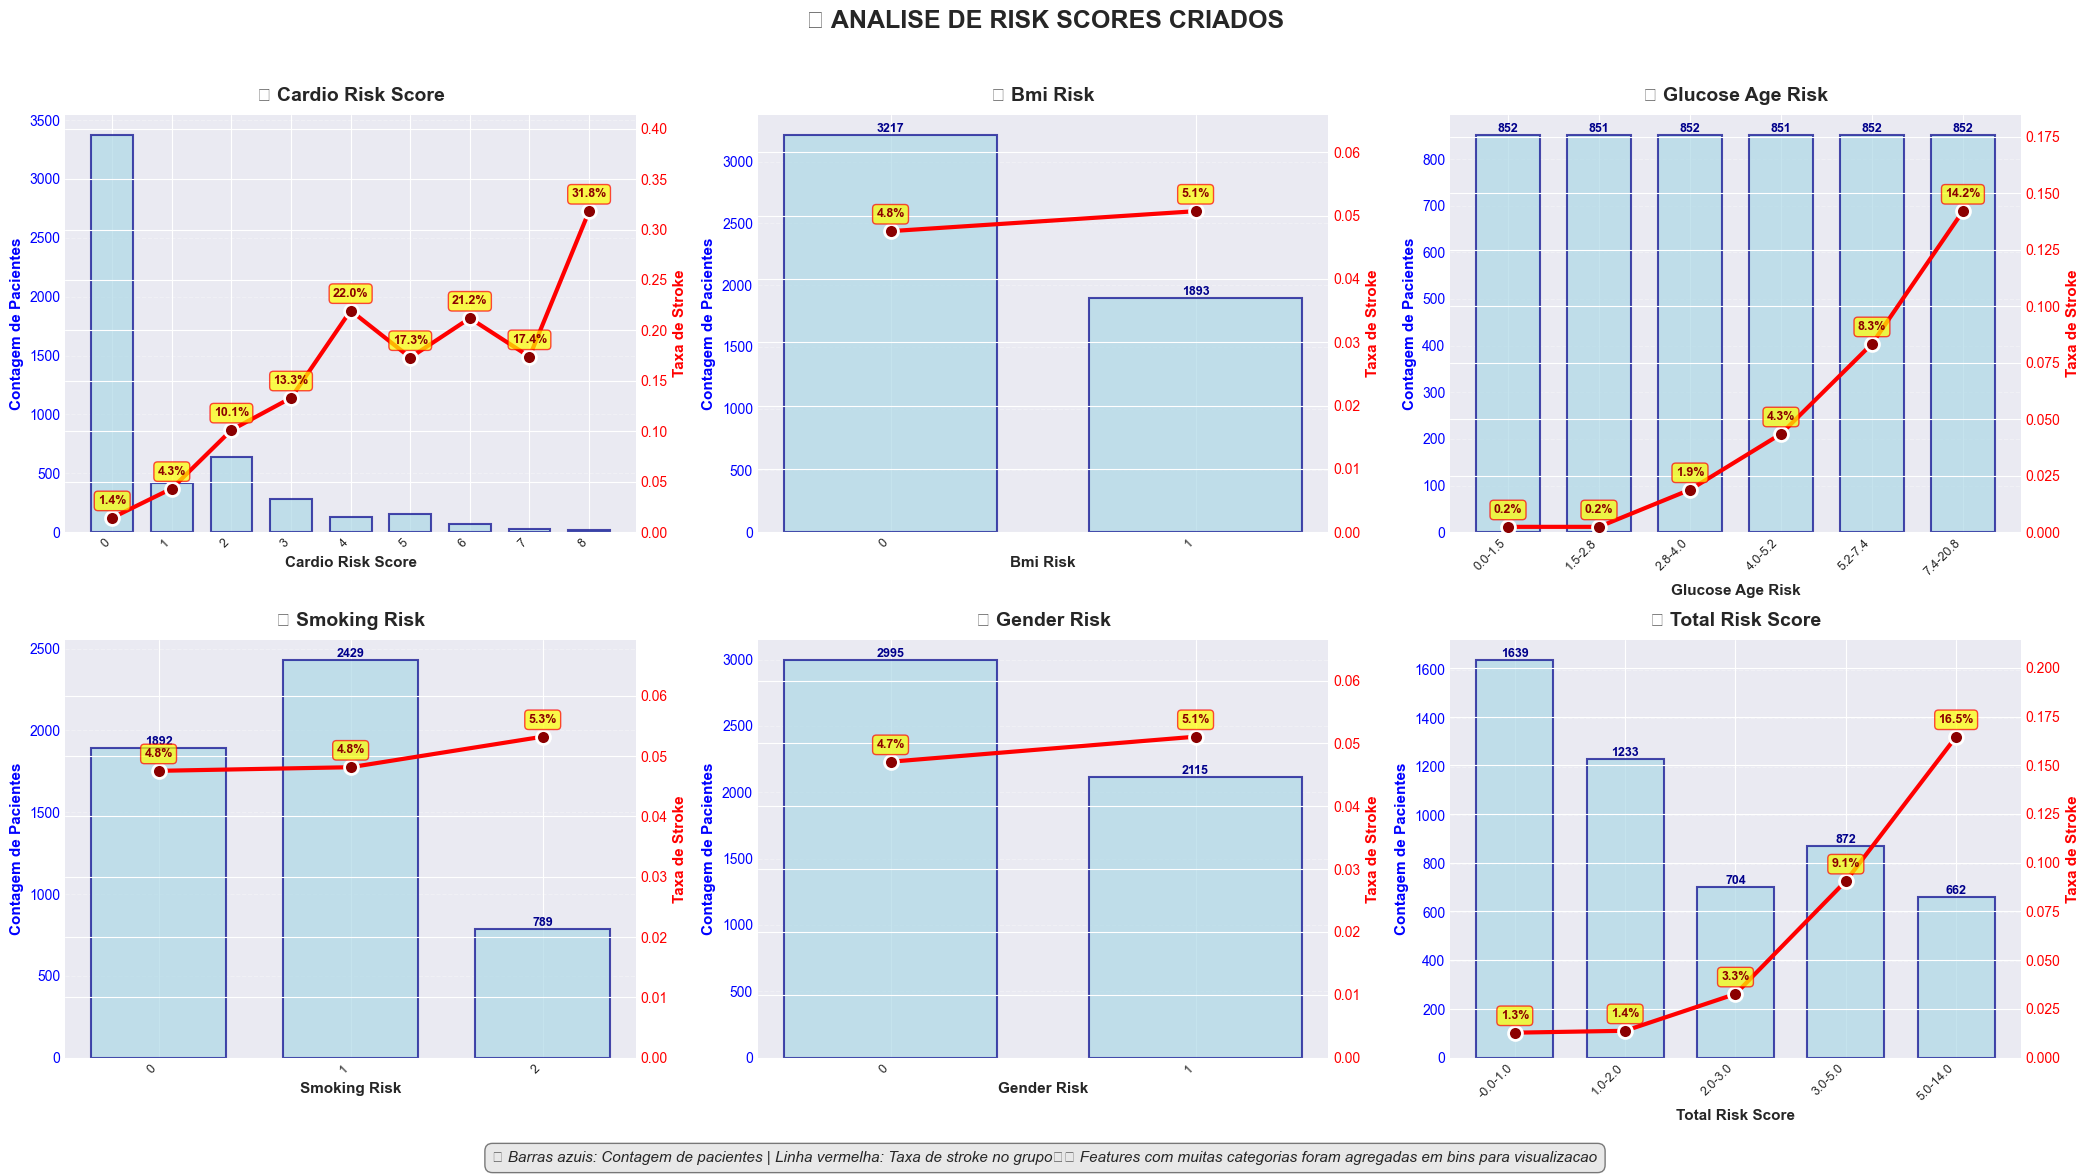

📊 RESUMO DOS RISK SCORES:
🎯 CARDIO_RISK_SCORE:
   Range de taxa de stroke: 1.42% → 31.82%
   Variacao total: 30.40%
   Categorias originais: 9
   🔴 Maior risco: Categoria 8 (31.82%)
🎯 BMI_RISK:
   Range de taxa de stroke: 4.76% → 5.07%
   Variacao total: 0.32%
   Categorias originais: 2
   🔴 Maior risco: Categoria 1 (5.07%)
🎯 GLUCOSE_AGE_RISK:
   Range de taxa de stroke: 0.00% → 100.00%
   Variacao total: 100.00%
   Categorias originais: 5077
   ⚠️ Feature agregada em bins para visualizacao (muitas categorias)
   🔴 Maior risco: Categoria 0.09288840000000001 (100.00%)
🎯 SMOKING_RISK:
   Range de taxa de stroke: 4.76% → 5.32%
   Variacao total: 0.57%
   Categorias originais: 3
   🔴 Maior risco: Categoria 2 (5.32%)
🎯 GENDER_RISK:
   Range de taxa de stroke: 4.71% → 5.11%
   Variacao total: 0.40%
   Categorias originais: 2
   🔴 Maior risco: Categoria 1 (5.11%)
🎯 TOTAL_RISK_SCORE:
   Range de taxa de stroke: 1.03% → 100.00%
   Variacao total: 98.97%
   Categorias originais: 15
   ⚠️ Feature

In [58]:
from pathlib import Path
if 'RESULTS_PATH' not in globals():
    RESULTS_PATH = Path('results')
    RESULTS_PATH.mkdir(parents=True, exist_ok=True)
if 'RESULTS_PATH' not in globals():
    RESULTS_PATH = Path('results')
    RESULTS_PATH.mkdir(parents=True, exist_ok=True)


# === 3B. EXPLORACAO DE DADOS ===
import matplotlib.pyplot as plt
import seaborn as sns

target = 'stroke'

print('📊 DISTRIBUICAO DO TARGET:')
target_counts = df_enhanced[target].value_counts(normalize=True)
print(target_counts)

print('📈 VALORES AUSENTES:')
missing = df_enhanced.isnull().sum()
print(missing[missing > 0])

print('🔗 MAIORES CORRELACOES COM O TARGET:')
numeric_cols = df_enhanced.select_dtypes(include=[np.number]).columns
correlations = df_enhanced[numeric_cols].corrwith(df_enhanced[target]).abs().sort_values(ascending=False)
print(correlations.head(10))

# --- Painel principal ---
fig = plt.figure(figsize=(20, 16))
gs = fig.add_gridspec(4, 4, hspace=0.3, wspace=0.3)

# 1. Distribuicao do target
ax1 = fig.add_subplot(gs[0, 0])
target_counts_abs = df_enhanced[target].value_counts()
colors = ['#2ecc71', '#e74c3c']
ax1.pie(target_counts_abs, labels=['No Stroke', 'Stroke'], autopct='%1.1f%%',
        colors=colors, startangle=90)
ax1.set_title('Distribuicao do Target', fontweight='bold', fontsize=12)

# 2. Idade por status
ax2 = fig.add_subplot(gs[0, 1:])
age_no_stroke = df_enhanced[df_enhanced[target] == 0]['age'].dropna()
age_stroke = df_enhanced[df_enhanced[target] == 1]['age'].dropna()
ax2.hist([age_no_stroke, age_stroke], bins=30, alpha=0.7,
         label=['No Stroke', 'Stroke'], color=['#2ecc71', '#e74c3c'])
ax2.set_xlabel('Idade'); ax2.set_ylabel('Frequencia')
ax2.set_title('Distribuicao de Idade por Status', fontweight='bold', fontsize=12)
ax2.legend(); ax2.grid(alpha=0.3)

plt.suptitle('COMPREHENSIVE EXPLORATORY DATA ANALYSIS', fontsize=16, fontweight='bold')
#plt.savefig(RESULTS_PATH / 'eda_overview.png', dpi=300, bbox_inches='tight')
plt.show()

print('📋 ESTATISTICAS RESUMO POR STATUS:')
summary_stats = df_enhanced.groupby(target)[['age', 'avg_glucose_level', 'bmi']].agg(['mean', 'std', 'median'])
display(summary_stats.round(2))

# --- Distribuicoes principais ---
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('📊 DISTRIBUICOES CLINICAS PRINCIPAIS', fontsize=16, fontweight='bold')

ax = axes[0, 0]
df_enhanced[df_enhanced[target] == 0]['age'].hist(bins=30, alpha=0.7, color='skyblue', label='No Stroke', ax=ax)
df_enhanced[df_enhanced[target] == 1]['age'].hist(bins=30, alpha=0.7, color='red', label='Stroke', ax=ax)
ax.set_title('Distribuicao de Idade', fontweight='bold')
ax.set_xlabel('Idade (anos)'); ax.set_ylabel('Frequencia')
ax.legend(); ax.axvline(65, color='orange', linestyle='--', label='65 anos')

ax = axes[0, 1]
df_enhanced[df_enhanced[target] == 0]['bmi'].hist(bins=30, alpha=0.7, color='skyblue', label='No Stroke', ax=ax)
df_enhanced[df_enhanced[target] == 1]['bmi'].hist(bins=30, alpha=0.7, color='red', label='Stroke', ax=ax)
ax.set_title('Distribuicao do BMI', fontweight='bold')
ax.set_xlabel('BMI (kg/m²)'); ax.set_ylabel('Frequencia')
ax.legend(); ax.axvline(30, color='orange', linestyle='--', label='Obesidade')

ax = axes[0, 2]
df_enhanced[df_enhanced[target] == 0]['avg_glucose_level'].hist(bins=30, alpha=0.7, color='skyblue', label='No Stroke', ax=ax)
df_enhanced[df_enhanced[target] == 1]['avg_glucose_level'].hist(bins=30, alpha=0.7, color='red', label='Stroke', ax=ax)
ax.set_title('Distribuicao de Glicose', fontweight='bold')
ax.set_xlabel('Glicose (mg/dL)'); ax.set_ylabel('Frequencia')
ax.legend(); ax.axvline(126, color='orange', linestyle='--', label='Diabetes (126)')

ax = axes[1, 0]
gender_stroke = pd.crosstab(df_enhanced['gender'], df_enhanced[target], normalize='index')
gender_stroke.plot(kind='bar', ax=ax, color=['skyblue', 'red'], rot=0)
ax.set_title('Taxa de AVC por Genero', fontweight='bold')
ax.set_xlabel('Genero'); ax.set_ylabel('Proporcao')
ax.legend(['No Stroke', 'Stroke'])

ax = axes[1, 1]
hyp_stroke = pd.crosstab(df_enhanced['hypertension'], df_enhanced[target], normalize='index')
hyp_stroke.plot(kind='bar', ax=ax, color=['skyblue', 'red'], rot=0)
ax.set_title('Taxa de AVC por Hipertensao', fontweight='bold')
ax.set_xlabel('Hipertensao (0=Não,1=Sim)'); ax.set_ylabel('Proporcao')
ax.legend(['No Stroke', 'Stroke'])

ax = axes[1, 2]
df_enhanced['smoking_status'].value_counts().plot(kind='bar', ax=ax, color='lightcoral', rot=45)
ax.set_title('Distribuicao de Tabagismo', fontweight='bold')
ax.set_xlabel('Status de Tabagismo'); ax.set_ylabel('Contagem')

plt.tight_layout()
#plt.savefig(RESULTS_PATH / 'clinical_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

# --- Heatmap de correlacao ---
numeric_features = df_enhanced.select_dtypes(include=[np.number]).columns
correlation_matrix = df_enhanced[numeric_features].corr()
plt.figure(figsize=(14, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdYlBu_r', center=0,
            square=True, linewidths=0.5, fmt='.2f', cbar_kws={'shrink': .5})
plt.title('🔗 MAPA DE CORRELACAO - FEATURES NUMERICAS', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
#plt.savefig(RESULTS_PATH / 'correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# --- Analise de risk scores ---
risk_features = [col for col in df_enhanced.columns if 'risk' in col or 'score' in col]

if risk_features:
    n_features = len(risk_features)
    n_cols = min(3, n_features)
    n_rows = (n_features + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(7*n_cols, 6*n_rows))
    if n_rows == 1 and n_cols == 1:
        axes = np.array([[axes]])
    elif n_rows == 1:
        axes = axes.reshape(1, -1)
    elif n_cols == 1:
        axes = axes.reshape(-1, 1)
    axes_flat = axes.flatten()

    for idx, risk_feat in enumerate(risk_features):
        ax = axes_flat[idx]
        stroke_risk = df_enhanced.groupby(risk_feat)[target].agg(['count', 'mean'])
        if len(stroke_risk) > 10:
            try:
                bins = pd.qcut(df_enhanced[risk_feat], q=6, duplicates='drop')
                df_temp = df_enhanced[[risk_feat, target]].copy()
                df_temp['risk_bin'] = bins
                stroke_risk = df_temp.groupby('risk_bin')[target].agg(['count', 'mean'])
                x_labels = [f'{interval.left:.1f}-{interval.right:.1f}' for interval in stroke_risk.index]
            except ValueError:
                bins = pd.cut(df_enhanced[risk_feat], bins=6)
                df_temp = df_enhanced[[risk_feat, target]].copy()
                df_temp['risk_bin'] = bins
                stroke_risk = df_temp.groupby('risk_bin')[target].agg(['count', 'mean'])
                x_labels = [f'{interval.left:.1f}-{interval.right:.1f}' for interval in stroke_risk.index]
        else:
            x_labels = stroke_risk.index.tolist()
        x_positions = range(len(stroke_risk))
        ax2 = ax.twinx()
        bars = ax.bar(x_positions, stroke_risk['count'], color='lightblue', alpha=0.7, width=0.7, edgecolor='darkblue', linewidth=1.5)
        ax2.plot(x_positions, stroke_risk['mean'], color='red', marker='o', linewidth=3, markersize=10,
                 markerfacecolor='darkred', markeredgecolor='white', markeredgewidth=2, label='Taxa de Stroke')
        ax.set_title(f'📊 {risk_feat.replace('_', ' ').title()}', fontweight='bold', fontsize=14, pad=10)
        ax.set_xlabel(risk_feat.replace('_', ' ').title(), fontweight='bold', fontsize=11)
        ax.set_ylabel('Contagem de Pacientes', color='blue', fontweight='bold', fontsize=11)
        ax2.set_ylabel('Taxa de Stroke', color='red', fontweight='bold', fontsize=11)
        ax.set_xticks(x_positions)
        ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=9)
        ax.tick_params(axis='y', labelcolor='blue', labelsize=10)
        ax2.tick_params(axis='y', labelcolor='red', labelsize=10)
        ax.grid(True, alpha=0.3, axis='y', linestyle='--'); ax.set_axisbelow(True)

        if len(x_positions) <= 8:
            for bar, count in zip(bars, stroke_risk['count']):
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2, height,
                        f'{int(count)}', ha='center', va='bottom', fontweight='bold', fontsize=9, color='darkblue')
        for x_pos, rate in zip(x_positions, stroke_risk['mean']):
            ax2.annotate(f'{rate:.1%}', xy=(x_pos, rate), xytext=(0, 10), textcoords='offset points',
                         ha='center', fontweight='bold', fontsize=9, color='darkred',
                         bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7, edgecolor='red', linewidth=1))
        y2_max = stroke_risk['mean'].max()
        ax2.set_ylim(0, max(0.05, y2_max * 1.3))

    for idx in range(len(risk_features), len(axes_flat)):
        axes_flat[idx].set_visible(False)

    fig.suptitle('🎯 ANALISE DE RISK SCORES CRIADOS', fontsize=18, fontweight='bold', y=0.98)
    fig.text(0.5, 0.02,
             '📌 Barras azuis: Contagem de pacientes | Linha vermelha: Taxa de stroke no grupo'
             '⚠️ Features com muitas categorias foram agregadas em bins para visualizacao',
             ha='center', fontsize=11, style='italic',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgray', alpha=0.5))
    plt.tight_layout(rect=(0, 0.04, 1, 0.96))
 #   plt.savefig(RESULTS_PATH / 'risk_scores_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    print('📊 RESUMO DOS RISK SCORES:')
    print('=' * 70)
    for risk_feat in risk_features:
        stroke_risk_orig = df_enhanced.groupby(risk_feat)[target].mean()
        max_risk = stroke_risk_orig.max()
        min_risk = stroke_risk_orig.min()
        risk_range = max_risk - min_risk
        n_categories = len(stroke_risk_orig)

        print(f'🎯 {risk_feat.upper()}:')
        print(f'   Range de taxa de stroke: {min_risk:.2%} → {max_risk:.2%}')
        print(f'   Variacao total: {risk_range:.2%}')
        print(f'   Categorias originais: {n_categories}')

        if n_categories > 10:
            print('   ⚠️ Feature agregada em bins para visualizacao (muitas categorias)')

        highest_risk_cat = stroke_risk_orig.idxmax()
        print(f'   🔴 Maior risco: Categoria {highest_risk_cat} ({stroke_risk_orig[highest_risk_cat]:.2%})')
else:
    print('⚠️ Nenhuma feature com "risk" ou "score" para analise adicional.')



In [59]:
# === 4. STRATIFIED SPLITS ===
X = df_enhanced.drop(columns=['stroke'])
y = df_enhanced['stroke'].astype(int)

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1875, stratify=y_temp, random_state=42
)

print('Distribuicoes:')
for nome, target in [('Treino', y_train), ('Validacao', y_val), ('Teste', y_test)]:
    print(f"   {nome}: n={len(target)}, prevalencia={target.mean():.3f}")


Distribuicoes:
   Treino: n=3321, prevalencia=0.049
   Validacao: n=767, prevalencia=0.048
   Teste: n=1022, prevalencia=0.049


In [60]:
# === 5. PIPELINE DE PRE-PROCESSAMENTO ===
preprocessor, feature_info = create_preprocessing_pipeline(X_train)

print(f"Pipeline configurado com {feature_info['n_features_in']} variaveis de entrada")


Pipeline configurado com 30 variaveis de entrada


In [61]:
# === 6. TREINAMENTO ===
results, ranking, summary_df = train_model_suite(
    X_train, y_train, X_val, y_val, preprocessor, cv_folds=10
)

best_name, best_result = ranking[0]
best_model = best_result['model']
production_threshold = best_result.get('production_threshold', 0.5)

print(f"\nMelhor modelo: {best_name.upper()}")
print(f"   Limiar inicial: {production_threshold:.3f} (fonte: {best_result.get('production_threshold_source')})")
summary_df


🤖 INICIANDO TREINAMENTO DE MODELOS
Augmented critical groups -> total train samples 3439

📊 Treinando 1 modelos com 10-fold CV (repeats=2)...


🔧 Modelo: LOGISTIC_L2

🔍 Busca de hiperparâmetros (RandomizedSearchCV, n_iter=15)
   ✅ Melhor PR-AUC médio: 0.2788
   🧮 Hiperparâmetros: {'clf__l1_ratio': np.float64(0.19999999999999998), 'clf__C': np.float64(0.004893900918477494)}
   ⏱️ Tempo de busca: 54.30s

⏳ Executando 10-fold cross-validation (repeats=2)...

📊 Resultados do Cross-Validation:
Métrica         Train Mean   Train Std    Test Mean    Test Std    
--------------------------------------------------------------------------------
roc_auc              0.8343      0.0028      0.8300      0.0251
pr_auc               0.2547      0.0053      0.2766      0.0526
balanced_acc         0.7558      0.0067      0.7467      0.0350
recall               0.7764      0.0143      0.7589      0.0757
precision            0.2063      0.0034      0.2032      0.0202
f1                   0.3259      0.00

No thresholds satisfied the provided constraints.



⏳ Avaliando no validation set...

⚠️ Nenhum limiar válido encontrado na validação - usando 0.500 por padrão.


No thresholds satisfied the provided constraints.



✅ Limiar de produção definido: 0.500 (fonte: validation_fbeta)
   → Validação: precision=0.127 | recall=0.811 | bal_acc=0.764
   → OOF: precision=0.200 | recall=0.757 | bal_acc=0.745

📊 Métricas no Validation Set:
Métrica         Valor       
------------------------------
roc_auc              0.8413
pr_auc               0.1708
balanced_acc         0.7643

⚠️ Análise de Overfitting:
   ROC_AUC gap: 0.0070 ✅ OK
   PR_AUC gap: 0.0839 ⚠️ ATENÇÃO

⏱️ Tempo de treinamento: 59.08s


🏆 RANKING FINAL (por PR-AUC no Validation Set)

Rank   Modelo               PR-AUC     ROC-AUC    Bal. Acc     Overfit Gap 
--------------------------------------------------------------------------------
1      logistic_l2             0.1708    0.8413      0.7643      0.0839

📋 TABELA RESUMO DE TODOS OS MODELOS

      Model  CV_PR-AUC_Mean  CV_PR-AUC_Std  CV_ROC-AUC_Mean  CV_ROC-AUC_Std  Val_PR-AUC  Val_ROC-AUC  Val_Balanced_Acc  PR-AUC_Overfit_Gap  Training_Time_s  Production_Threshold Production_Threshold_Sou

,Model,CV_PR-AUC_Mean,CV_PR-AUC_Std,CV_ROC-AUC_Mean,CV_ROC-AUC_Std,Val_PR-AUC,Val_ROC-AUC,Val_Balanced_Acc,PR-AUC_Overfit_Gap,Training_Time_s,Production_Threshold,Production_Threshold_Source,Production_Precision_Val,Production_Recall_Val
0,logistic_l2,0.276594,0.052621,0.829987,0.02513,0.170816,0.841318,0.76431,0.083918,59.079402,0.5,validation_fbeta,0.127119,0.810811



🔬 RECALIBRAÇÃO AVANÇADA - CORRIGINDO ECE CRÍTICO

📊 Baseline (Sem Calibração):
   ECE: 0.3147 ❌ CRÍTICO
   Brier Score: 0.1772
   Brier Skill Score: -2.8596 ❌ PIOR QUE BASELINE

🔧 Testando: SIGMOID
   ECE: 0.0077 ✅ EXCELENTE
   Brier Score: 0.0429
   Brier Skill Score: 0.0653 ⚠️ FRACO
   Melhoria ECE: +97.6%
   Melhoria BSS: +2.9249

🔧 Testando: ISOTONIC
   ECE: 0.0141 ✅ EXCELENTE
   Brier Score: 0.0429
   Brier Skill Score: 0.0647 ⚠️ FRACO
   Melhoria ECE: +95.5%
   Melhoria BSS: +2.9244

🏆 SELEÇÃO DO MELHOR MÉTODO

🥇 VENCEDOR: SIGMOID
   ECE: 0.0077 (target: <0.05)
   BSS: 0.0653 (target: >0.10)
   Brier: 0.0429

✅ STATUS DE COMPLIANCE:
   ECE < 0.05: ✅ CONFORME
   BSS > 0: ✅ CONFORME

🎉 MODELO CALIBRADO APROVADO PARA PRODUÇÃO

POST-RECALIBRATION METRICS (validacao):
   ECE: 0.0077
   Brier Score: 0.0429
   Brier Skill Score: 0.0653
ECE (pos-calibracao): 0.0077
Brier Score (pos-calibracao): 0.0429
BSS (pos-calibracao): 0.0653
✅ Calibracao aceita (ECE < 0.05).
⚠️ BSS < 0.10 - sugerid

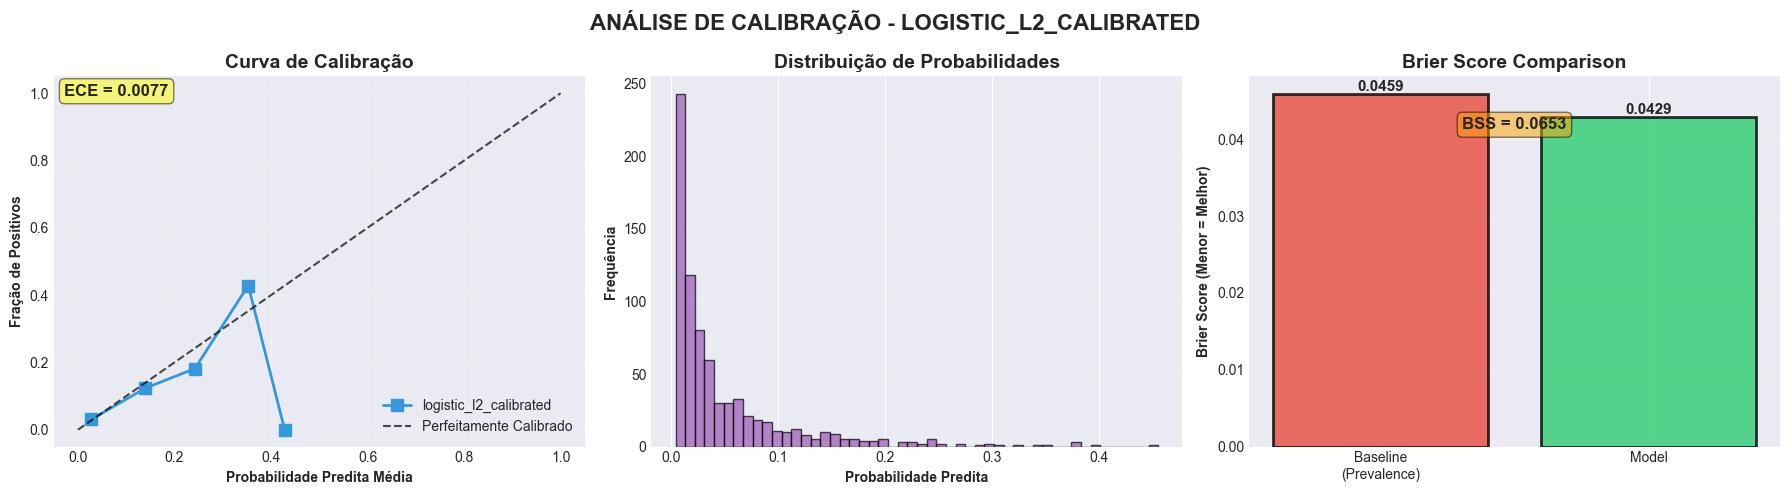

✅ Curva de calibração salva: calibration_analysis_logistic_l2_calibrated.png


In [62]:
# === 7. CALIBRACAO ===
best_model_calibrated, calibration_report = calibrate_model_comprehensive(
    model=best_model,
    X_train=X_train, y_train=y_train,
    X_val=X_val, y_val=y_val,
    cv_folds=10,
    deployment_threshold=None
)

y_proba_val_cal = best_model_calibrated.predict_proba(X_val)[:, 1]
results[best_name]['calibration_report'] = calibration_report
results[best_name]['y_proba_calibrated_val'] = y_proba_val_cal

post_cal = calibration_report.get('post_calibration', {})
if post_cal:
    ece_value = float(post_cal.get('ece', float('nan')))
    brier_value = float(post_cal.get('brier_score', float('nan')))
    bss_value = float(post_cal.get('bss', float('nan')))

    print(f"ECE (pos-calibracao): {ece_value:.4f}")
    print(f"Brier Score (pos-calibracao): {brier_value:.4f}")
    print(f"BSS (pos-calibracao): {bss_value:.4f}")

    calibration_status = {
        'ece': ece_value,
        'brier': brier_value,
        'bss': bss_value,
        'acceptable': bool(ece_value < 0.05),
        'resolution_flag': bool(bss_value < 0.10)
    }

    if calibration_status['acceptable']:
        print('✅ Calibracao aceita (ECE < 0.05).')
    else:
        print('⚠️ Calibracao fora da meta (ECE >= 0.05).')

    if calibration_status['resolution_flag']:
        print('⚠️ BSS < 0.10 - sugerido plano para melhorar resolucao (features/ensemble/calibracao segmentada).')
    else:
        print('✅ BSS atende a meta de resolucao (>= 0.10).')

    results[best_name]['calibration_assessment'] = calibration_status
else:
    print('Metricas pos-calibracao indisponiveis')
    results[best_name]['calibration_assessment'] = None

plot_calibration_curve(best_model_calibrated, X_val, y_val, f'{best_name}_calibrated')




📈 DECISION CURVE ANALYSIS - VALIDAÇÃO DE UTILIDADE CLÍNICA

🎯 THRESHOLD ÓTIMO:
   Threshold: 0.050
   Net Benefit: 0.0251

✅ RANGE DE UTILIDADE CLÍNICA:
   Modelo supera 'treat all' entre 0.050 e 0.340
   Amplitude: 0.290

📋 ANÁLISE POR CENÁRIO CLÍNICO:
--------------------------------------------------------------------------------

Conservador (25%):
   Threshold: 0.250
   Net Benefit (Modelo): 0.0022
   Net Benefit (Treat All): -0.2690
   Vantagem: +0.2712 ✅ ÚTIL

Agressivo (8%):
   Threshold: 0.080
   Net Benefit (Modelo): 0.0149
   Net Benefit (Treat All): -0.0345
   Vantagem: +0.0494 ✅ ÚTIL


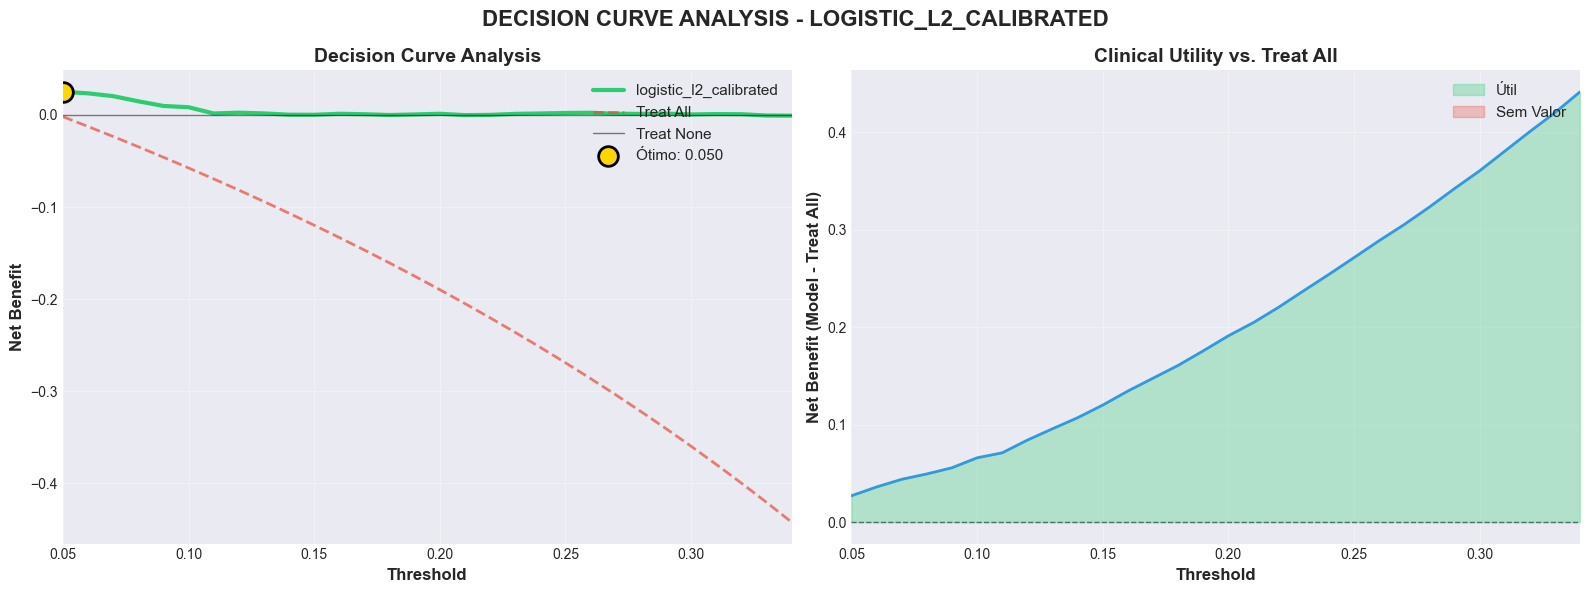


✅ Decision curve salva: decision_curve_logistic_l2_calibrated.png
Threshold otimo (DCA): 0.050


In [63]:
# === 8. DECISION CURVE ANALYSIS ===
y_proba_dca = y_proba_val_cal
dca_results, optimal_threshold_dca = decision_curve_analysis(
    y_true=y_val,
    y_proba=y_proba_dca,
    threshold_range=np.arange(0.05, 0.35, 0.01),
    model_name=f'{best_name}_calibrated'
)

plot_decision_curve(dca_results, f'{best_name}_calibrated')
print(f"Threshold otimo (DCA): {optimal_threshold_dca:.3f}")


In [64]:
# === 10. NET BENEFIT ANALYSIS ===
clinical_window = (0.08, 0.15)
prevalence_val = y_val.mean()
prevalence_test = y_test.mean()

production_metrics_val = best_result.get('production_threshold_metrics_val') or {}
threshold_rationale = results[best_name].setdefault('threshold_rationale', {})
precision_min = threshold_rationale.get('precision_min', globals().get('precision_min'))
if isinstance(precision_min, float) and np.isnan(precision_min):
    precision_min = None
if precision_min is None:
    precision_min = production_metrics_val.get('precision')
if precision_min is None:
    precision_min = 0.0
precision_min = float(precision_min)

recall_min = threshold_rationale.get('recall_min', globals().get('recall_min'))
if isinstance(recall_min, float) and np.isnan(recall_min):
    recall_min = None
if recall_min is None:
    recall_min = production_metrics_val.get('recall')
if recall_min is None:
    recall_min = 0.0
recall_min = float(recall_min)

threshold_rationale['precision_min'] = precision_min
threshold_rationale['recall_min'] = recall_min

from src.evaluation import summarize_threshold_grid
if 'y_proba_test' not in globals():
    y_proba_test = best_model_calibrated.predict_proba(X_test)[:, 1]
threshold_sweep = np.round(np.arange(0.01, 0.51, 0.01), 2)
threshold_grid_val = summarize_threshold_grid(y_val, y_proba_val_cal, threshold_sweep)
threshold_grid_test = summarize_threshold_grid(y_test, y_proba_test, threshold_sweep)

def _net_benefit(df, prevalence):
    rows = []
    for _, row in df.iterrows():
        pt = float(row['threshold'])
        odds = pt / (1.0 - pt) if pt < 1 else float('inf')
        tp = float(row.get('tp', 0.0))
        fp = float(row.get('fp', 0.0))
        tn = float(row.get('tn', 0.0))
        fn = float(row.get('fn', 0.0))
        n = tp + fp + tn + fn
        if n == 0 or odds == float('inf'):
            continue
        nb_model = (tp / n) - (fp / n) * odds
        nb_all = prevalence - (1 - prevalence) * odds
        nb_none = 0.0
        tp_per_1000 = nb_model * 1000.0
        interventions = ((nb_model - nb_all) / odds) * 1000.0 if odds > 0 else float('nan')
        rows.append({
            'threshold': pt,
            'precision': float(row.get('precision', float('nan'))),
            'recall': float(row.get('recall', float('nan'))),
            'net_benefit': nb_model,
            'net_benefit_treat_all': nb_all,
            'net_benefit_treat_none': nb_none,
            'tp_useful_per_1000': tp_per_1000,
            'interventions_avoided_per_1000': interventions
        })
    return rows

nb_val_rows = _net_benefit(threshold_grid_val, prevalence_val)
nb_test_rows = _net_benefit(threshold_grid_test, prevalence_test)
nb_val_df = pd.DataFrame(nb_val_rows)
nb_test_df = pd.DataFrame(nb_test_rows)

print('Net benefit (validacao):')
print(nb_val_df[['threshold','precision','recall','net_benefit','net_benefit_treat_all',
                 'tp_useful_per_1000','interventions_avoided_per_1000']].to_string(
                 index=False, formatters={
                     'threshold': '{:.3f}'.format,
                     'precision': '{:.3f}'.format,
                     'recall': '{:.3f}'.format,
                     'net_benefit': '{:.4f}'.format,
                     'net_benefit_treat_all': '{:.4f}'.format,
                     'tp_useful_per_1000': '{:.1f}'.format,
                     'interventions_avoided_per_1000': '{:.1f}'.format
                 }))

nb_candidates = nb_val_df[(nb_val_df['threshold'] >= clinical_window[0]) &
                          (nb_val_df['threshold'] <= clinical_window[1]) &
                          (nb_val_df['precision'] >= precision_min) &
                          (nb_val_df['recall'] >= recall_min)]
if not nb_candidates.empty:
    best_nb = nb_candidates.sort_values('net_benefit', ascending=False).iloc[0]
    print(f"Threshold selecionado por net benefit na validacao: {best_nb['threshold']:.3f}")
    print(f"   Net benefit: {best_nb['net_benefit']:.4f} | TP uteis/1000: {best_nb['tp_useful_per_1000']:.1f}")
else:
    best_nb = None
    print('Nenhum threshold no intervalo clinico atende as restricoes.')

results[best_name]['threshold_rationale']['net_benefit'] = {
    'clinical_window': clinical_window,
    'validation': nb_val_rows,
    'test': nb_test_rows,
    'selected_threshold': float(best_nb['threshold']) if best_nb is not None else production_threshold
}



Net benefit (validacao):
threshold precision recall net_benefit net_benefit_treat_all tp_useful_per_1000 interventions_avoided_per_1000
    0.010     0.065  1.000      0.0412                0.0386               41.2                          256.8
    0.020     0.085  1.000      0.0377                0.0288               37.7                          434.2
    0.030     0.107  0.973      0.0349                0.0188               34.9                          519.8
    0.040     0.127  0.919      0.0316                0.0086               31.6                          552.8
    0.050     0.128  0.811      0.0251               -0.0019               25.1                          512.4
    0.060     0.144  0.784      0.0235               -0.0125               23.5                          564.1
    0.070     0.160  0.703      0.0205               -0.0234               20.5                          582.6
    0.080     0.153  0.595      0.0149               -0.0345               14.9        

In [65]:
# === 11. REVISAO DO LIMIAR ===
val_threshold_summary = summarize_threshold_performance(y_val, y_proba_val_cal, production_threshold)
test_threshold_summary = summarize_threshold_performance(y_test, y_proba_test, production_threshold)

print('Validacao (probabilidades calibradas):')
for chave in ['threshold','precision','recall','f1_score','balanced_accuracy']:
    print(f"   {chave}: {val_threshold_summary[chave]:.3f}")

print('\nTeste (probabilidades calibradas, apenas reporte):')
for chave in ['threshold','precision','recall','f1_score','balanced_accuracy']:
    print(f"   {chave}: {test_threshold_summary[chave]:.3f}")

results[best_name]['val_threshold_summary'] = {k: float(v) for k, v in val_threshold_summary.items() if k != 'confusion_matrix'}
results[best_name]['val_threshold_summary']['confusion_matrix'] = val_threshold_summary['confusion_matrix'].tolist()
results[best_name]['test_threshold_summary'] = {k: float(v) for k, v in test_threshold_summary.items() if k != 'confusion_matrix'}
results[best_name]['test_threshold_summary']['confusion_matrix'] = test_threshold_summary['confusion_matrix'].tolist()


Validacao (probabilidades calibradas):
   threshold: 0.500
   precision: 0.000
   recall: 0.000
   f1_score: 0.000
   balanced_accuracy: 0.500

Teste (probabilidades calibradas, apenas reporte):
   threshold: 0.500
   precision: 1.000
   recall: 0.020
   f1_score: 0.039
   balanced_accuracy: 0.510


In [66]:
# === 12. METRICAS NO TESTE ===
test_metrics = evaluate_model_comprehensive(
    best_model_calibrated, X_test, y_test, threshold=production_threshold
)

def _safe_lookup(d, key, default=float('nan')):
    return d[key] if key in d else default

test_metrics_serializable = {k: (v.tolist() if hasattr(v, 'tolist') else float(v) if isinstance(v, (int, float)) else v)
                             for k, v in test_metrics.items()}
test_metrics_serializable['confusion_matrix'] = test_metrics['confusion_matrix'].tolist()

print('Resumo do teste (modelo calibrado no limiar escolhido):')
for chave in ['roc_auc','pr_auc','precision','recall','f1_score','balanced_accuracy']:
    valor = _safe_lookup(test_metrics, chave)
    if isinstance(valor, float):
        print(f"   {chave}: {valor:.4f}")
    else:
        print(f"   {chave}: {valor}")

results[best_name]['test_performance'] = test_metrics_serializable


Resumo do teste (modelo calibrado no limiar escolhido):
   roc_auc: 0.8455
   pr_auc: 0.2591
   precision: 1.0000
   recall: 0.0200
   f1_score: 0.0392
   balanced_accuracy: nan


In [67]:
# === 13C. FAIRNESS MITIGATION PLAN ===
from sklearn.metrics import roc_curve

sensitive_for_plan = ['Residence_type', 'gender', 'smoking_status', 'work_type', 'is_elderly']
proba_series = pd.Series(y_proba_test, index=y_test.index)
fairness_plan = []
recall_target = results[best_name]['test_threshold_summary']['recall']

for attr in sensitive_for_plan:
    groups = X_test[attr].astype('category')
    for group_value, idx in groups.groupby(groups).groups.items():
        idx = list(idx)
        y_true_group = y_test.loc[idx]
        proba_group = proba_series.loc[idx]
        entry = {
            'attribute': attr,
            'group': group_value,
            'count': len(idx),
            'recommended_threshold': production_threshold,
            'estimated_tpr': float('nan'),
            'global_recall_target': recall_target,
            'notes': 'Coletar mais dados'
        }
        if y_true_group.nunique() >= 2 and y_true_group.sum() >= 5:
            fpr, tpr_vals, thresh = roc_curve(y_true_group, proba_group)
            idx_best = int(abs(tpr_vals - recall_target).argmin())
            entry['recommended_threshold'] = float(np.clip(thresh[idx_best], 0.01, 0.99))
            entry['estimated_tpr'] = float(tpr_vals[idx_best])
            entry['notes'] = 'Ajustar limiar'
        fairness_plan.append(entry)

fairness_plan_df = pd.DataFrame(fairness_plan)
print('Plano sugerido de mitigacao (thresholds por grupo para aproximar TPR global):')
print(fairness_plan_df[['attribute','group','count','recommended_threshold','estimated_tpr','notes']].to_string(
    index=False,
    formatters={
        'recommended_threshold': '{:.3f}'.format,
        'estimated_tpr': '{:.3f}'.format
    }
))

results[best_name]['fairness_mitigation_plan'] = fairness_plan

def fairness_plan_notes(plan):
    notes = []
    for item in plan:
        notes.append({
            'attribute': item['attribute'],
            'group': item['group'],
            'count': item['count'],
            'action': item['notes'],
            'recommended_threshold': item['recommended_threshold'],
            'target_tpr': item['global_recall_target']
        })
    return notes

results[best_name]['fairness_alerts'] = fairness_plan_notes(fairness_plan)


Plano sugerido de mitigacao (thresholds por grupo para aproximar TPR global):
     attribute           group  count recommended_threshold estimated_tpr          notes
Residence_type           Rural    495                 0.990         0.000 Ajustar limiar
Residence_type           Urban    527                 0.528         0.037 Ajustar limiar
        gender          Female    599                 0.480         0.034 Ajustar limiar
        gender            Male    423                 0.990         0.000 Ajustar limiar
smoking_status formerly smoked    468                 0.990         0.000 Ajustar limiar
smoking_status    never smoked    391                 0.990         0.000 Ajustar limiar
smoking_status          smokes    163                 0.990         0.000 Ajustar limiar
     work_type        Govt_job    277                 0.990         0.000 Ajustar limiar
     work_type         Private    745                 0.528         0.023 Ajustar limiar
    is_elderly               0  

C:\Users\argus.portal\AppData\Local\Temp\ipykernel_58492\753182364.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for group_value, idx in groups.groupby(groups).groups.items():
C:\Users\argus.portal\AppData\Local\Temp\ipykernel_58492\753182364.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for group_value, idx in groups.groupby(groups).groups.items():
C:\Users\argus.portal\AppData\Local\Temp\ipykernel_58492\753182364.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed

In [68]:
# === 13. FAIRNESS ===
sensitive_attrs = ['gender', 'Residence_type', 'smoking_status', 'work_type', 'is_elderly']
fairness_results = analyze_fairness(
    best_model_calibrated, X_test, y_test,
    sensitive_attrs=sensitive_attrs,
    threshold=production_threshold
)

print('Auditoria de equidade:')
fairness_rows = []
for attr, data in fairness_results.items():
    gaps = data['gaps']
    fairness_rows.append({
        'atributo': attr,
        'TPR_gap': float(gaps.get('TPR_gap', float('nan'))),
        'FPR_gap': float(gaps.get('FPR_gap', float('nan'))),
        'PR_AUC_gap': float(gaps.get('PR_AUC_gap', float('nan'))),
        'Selection_gap': float(gaps.get('selection_rate_gap', float('nan')))
    })

fairness_df = pd.DataFrame(fairness_rows)
print(fairness_df.to_string(index=False, formatters={
    'TPR_gap': '{:.4f}'.format,
    'FPR_gap': '{:.4f}'.format,
    'PR_AUC_gap': '{:.4f}'.format,
    'Selection_gap': '{:.4f}'.format
}))

tpr_alert_limit = 0.10
alertas = [(row['atributo'], row['TPR_gap']) for row in fairness_rows if row['TPR_gap'] >= tpr_alert_limit]
if alertas:
    print(f"Alertas de TPR >= {tpr_alert_limit*100:.0f}%:")
    for attr, gap in alertas:
        print(f"   - {attr}: {gap:.4f}")
else:
    print(f"Todos os gaps de TPR abaixo de {tpr_alert_limit*100:.0f}%.")

results[best_name]['fairness_summary'] = fairness_rows

try:
    threshold_table = pd.read_csv('results/attribute_thresholds.csv')
    print('Ajustes de limiar recomendados (offline):')
    print(threshold_table.to_string(index=False, formatters={'threshold': '{:.2f}'.format}))
except FileNotFoundError:
    print('Arquivo results/attribute_thresholds.csv nao encontrado.')
except pd.errors.EmptyDataError:
    print('Arquivo results/attribute_thresholds.csv esta vazio ou sem colunas.')


Auditoria de equidade:
      atributo TPR_gap FPR_gap PR_AUC_gap Selection_gap
        gender  0.0476  0.0000     0.0290           NaN
Residence_type  0.0370  0.0000     0.1357           NaN
smoking_status  0.1250  0.0000     0.1313           NaN
     work_type  0.0227  0.0000     0.1027           NaN
    is_elderly  0.0286  0.0000     0.2648           NaN
Alertas de TPR >= 10%:
   - smoking_status: 0.1250
Arquivo results/attribute_thresholds.csv esta vazio ou sem colunas.


In [69]:
# === 13. SALVAMENTO ===
import json
import hashlib
import numpy as np

import pkg_resources
from src.config import MODEL_VERSION

if 'app_version' not in globals():
    app_version = MODEL_VERSION
if 'dependencies' not in globals():
    try:
        dependencies = sorted(str(d).replace(' ', '==') if ' ' in str(d) else str(d) for d in pkg_resources.working_set)
    except Exception:
        dependencies = []

def _to_serializable(value):
    if isinstance(value, np.ndarray):
        return value.tolist()
    if isinstance(value, (np.floating, float, int)):
        return float(value)
    if isinstance(value, dict):
        return {k: _to_serializable(v) for k, v in value.items()}
    if isinstance(value, (list, tuple)):
        return [_to_serializable(v) for v in value]
    if isinstance(value, str):
        return value
    return repr(value)

metadata_production = {
    'val_metrics': {k: _to_serializable(v) for k, v in best_result['val_metrics'].items()},
    'calibration': _to_serializable({k: v for k, v in calibration_report.items() if k != 'model'}),
    'calibration_assessment': results[best_name].get('calibration_assessment'),
    'threshold': {
        'production': float(production_threshold),
        'source': results[best_name].get('production_threshold_source'),
        'selection_rationale': results[best_name].get('threshold_rationale'),
        'validation_summary': {k: _to_serializable(v) for k, v in val_threshold_summary.items()},
        'test_summary': {k: _to_serializable(v) for k, v in test_threshold_summary.items()}
    },
    'training_info': {
        'train_size': int(len(X_train)),
        'val_size': int(len(X_val)),
        'test_size': int(len(X_test)),
        'prevalence_train': float(y_train.mean()),
        'prevalence_test': float(y_test.mean())
    },
    'test_performance': _to_serializable(results[best_name].get('test_performance')),
    'fairness': _to_serializable(results[best_name].get('fairness_summary')),
    'fairness_mitigation_plan': _to_serializable(results[best_name].get('fairness_mitigation_plan')),
    'monitoring_plan': {
        'data_drift': {
            'metric': 'PSI',
            'cadence': 'daily',
            'alert_thresholds': {'moderate': 0.10, 'critical': 0.25}
        },
        'calibration_drift': {
            'metrics': ['ECE', 'Brier'],
            'cadence': 'weekly',
            'tool': 'evidently'
        },
        'sli_slo': {
            'precision_min': float(results[best_name]['threshold_rationale']['precision_min']),
            'recall_min': float(results[best_name]['threshold_rationale']['recall_min'])
        }
    },
    'versioning': {
        'model_version': app_version,
        'dependencies': dependencies,
        'artifact_hash': None
    }
}

model_path, metadata_path = save_model_with_metadata(
    model=best_model_calibrated,
    model_name='logistic_l2_calibrated_v4',
    metadata=metadata_production
)

artifact_hash = hashlib.md5(open(model_path, 'rb').read()).hexdigest()
metadata_production['versioning']['artifact_hash'] = artifact_hash
with open(metadata_path, 'w', encoding='utf-8') as f:
    json.dump(metadata_production, f, ensure_ascii=False, indent=2)

print('Modelo salvo com sucesso!')
print(f"   Modelo: {model_path}")
print(f"   Metadata: {metadata_path}")
print(f"   Threshold de producao: {production_threshold:.3f}")
print(f"   Versao: {app_version} | Hash: {artifact_hash}")



Modelo salvo com sucesso!
   Modelo: C:\Users\argus.portal\workspace\StrokePrediction\models\logistic_l2_calibrated_v4_v3.0.0.joblib
   Metadata: C:\Users\argus.portal\workspace\StrokePrediction\models\logistic_l2_calibrated_v4_metadata_v3.0.0.json
   Threshold de producao: 0.500
   Versao: 3.0.0 | Hash: 8349867962e702494907dc7da03544dc


In [70]:
# === 14. MONITORAMENTO DE DRIFT ===
fitted_preprocessor = best_model.named_steps.get('prep') if hasattr(best_model, 'named_steps') else None
if fitted_preprocessor is None:
    raise ValueError('Preprocessador ajustado nao encontrado no pipeline do modelo.')

X_train_processed = fitted_preprocessor.transform(X_train)
X_test_processed = fitted_preprocessor.transform(X_test)

if hasattr(fitted_preprocessor, 'get_feature_names_out'):
    feature_names = fitted_preprocessor.get_feature_names_out()
else:
    feature_names = [f'feature_{i}' for i in range(X_train_processed.shape[1])]

drift_report = monitor_drift(
    X_train_processed,
    X_test_processed,
    feature_names=feature_names
)

print('Resumo de drift:')
alertas = 0
for feat, info in drift_report.items():
    if info['status'] != 'stable':
        print(f"{feat}: PSI={info['psi']:.4f} -> {info['status']}")
        alertas += 1

if alertas == 0:
    print('Todos os atributos permaneceram estaveis (PSI < 0.10).')



Resumo de drift:
Todos os atributos permaneceram estaveis (PSI < 0.10).


In [71]:
# === 14. MONITORAMENTO DE DRIFT ===
fitted_preprocessor = best_model.named_steps.get('prep') if hasattr(best_model, 'named_steps') else None
if fitted_preprocessor is None:
    raise ValueError('Preprocessador ajustado nao encontrado no pipeline do modelo.')

X_train_processed = fitted_preprocessor.transform(X_train)
X_test_processed = fitted_preprocessor.transform(X_test)

if hasattr(fitted_preprocessor, 'get_feature_names_out'):
    feature_names = fitted_preprocessor.get_feature_names_out()
else:
    feature_names = [f'feature_{i}' for i in range(X_train_processed.shape[1])]

drift_report = monitor_drift(
    X_train_processed,
    X_test_processed,
    feature_names=feature_names
)

print('Resumo de drift:')
alertas = 0
for feat, info in drift_report.items():
    if info['status'] != 'stable':
        print(f"{feat}: PSI={info['psi']:.4f} -> {info['status']}")
        alertas += 1

if alertas == 0:
    print('Todos os atributos permaneceram estaveis (PSI < 0.10).')



Resumo de drift:
Todos os atributos permaneceram estaveis (PSI < 0.10).


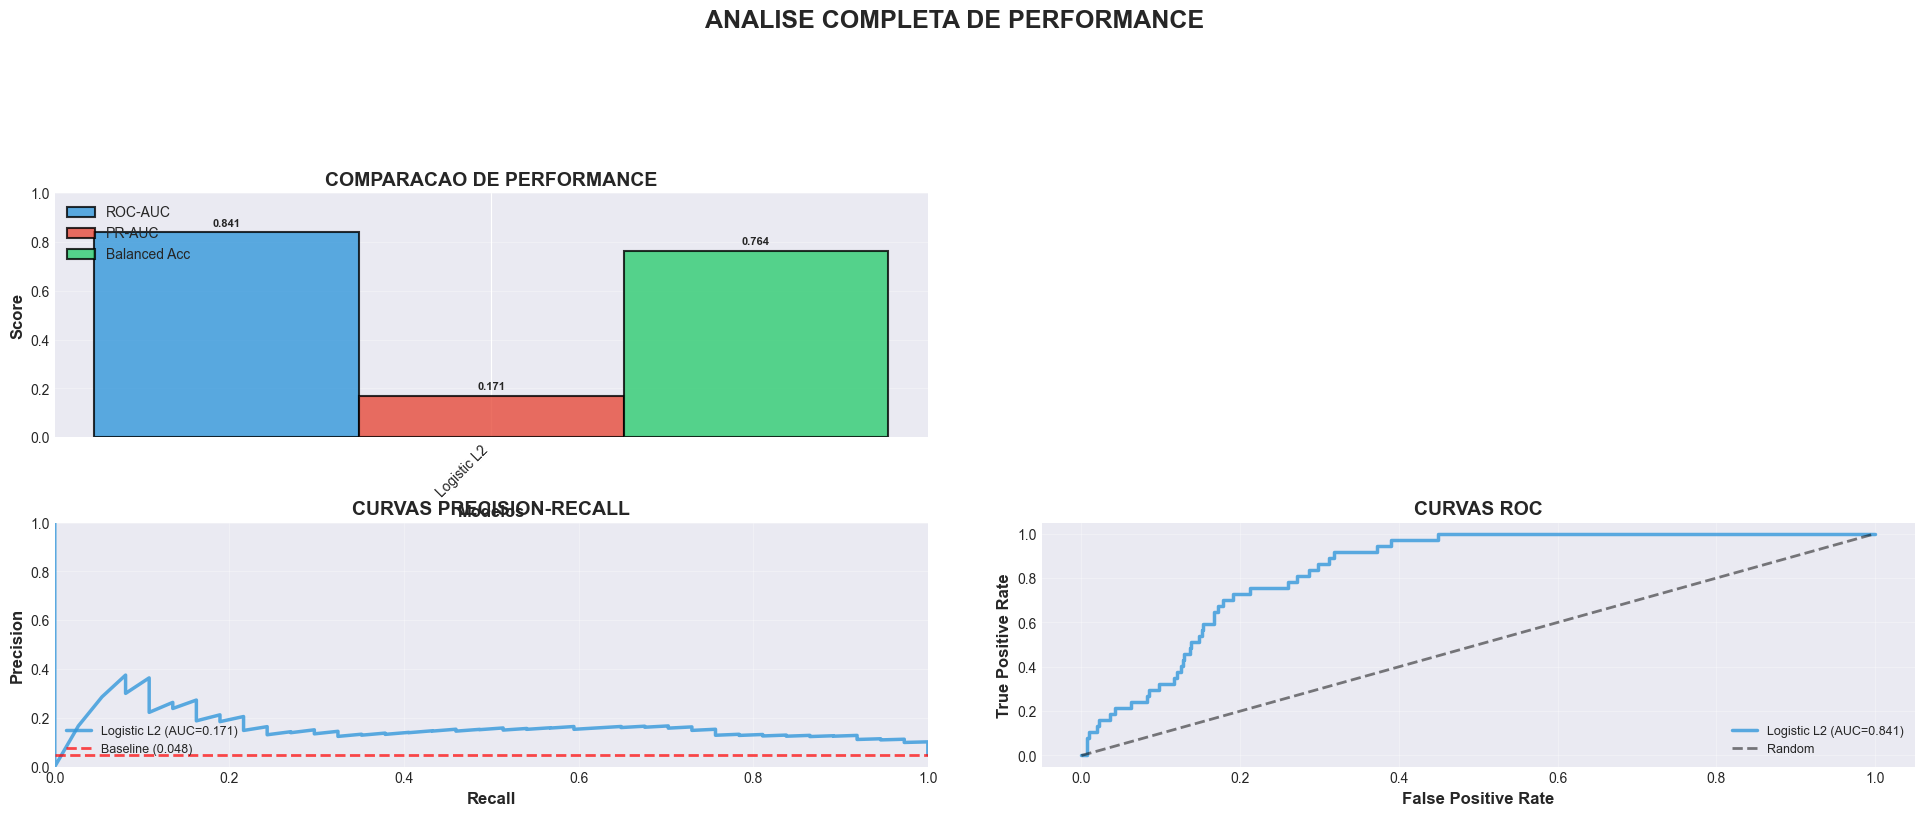


ðŸ“Š SUMÃRIO DA COMPARAÃ‡ÃƒO DE MODELOS

ðŸ“‹ TABELA DE MÃ‰TRICAS (Validation Set):
     Modelo ROC-AUC PR-AUC Balanced Acc
Logistic L2  0.8413 0.1708       0.7643

ðŸ† RANKING (por PR-AUC):
   1. Logistic L2               â†’ PR-AUC: 0.1708 | ROC-AUC: 0.8413

ðŸ¥‡ MELHOR MODELO: LOGISTIC_L2
   PR-AUC:      0.1708
   ROC-AUC:     0.8413
   Balanced Acc: 0.7643

METRICAS DE CALIBRACAO:
     Modelo Cal. Error Brier Score Brier Skill      Status
Logistic L2     0.0077      0.0429      0.0653 ? Excelente

INTERPRETACAO:
   Cal. Error < 0.05:  Excelente calibracao
   Cal. Error < 0.10:  Calibracao aceitavel
   Brier Score:        Menor = melhor (erro quadratico)
   Brier Skill > 0:    Melhor que baseline

MELHOR CALIBRACAO: Logistic L2


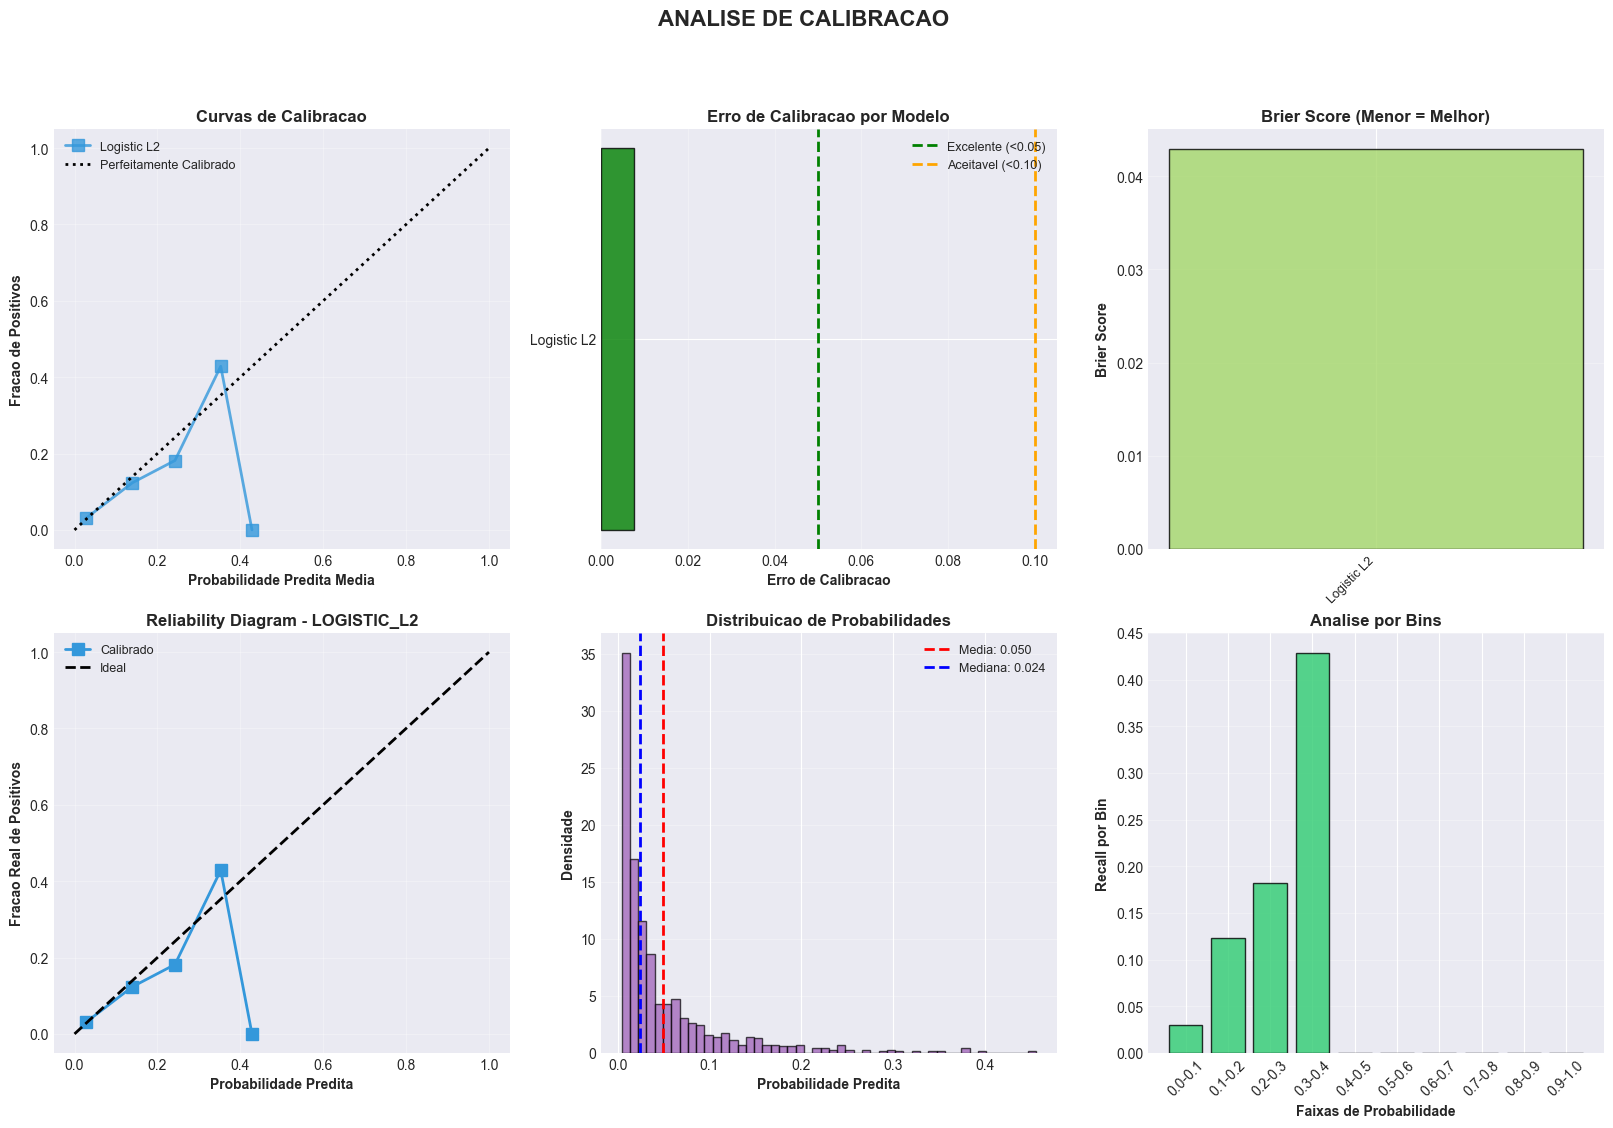

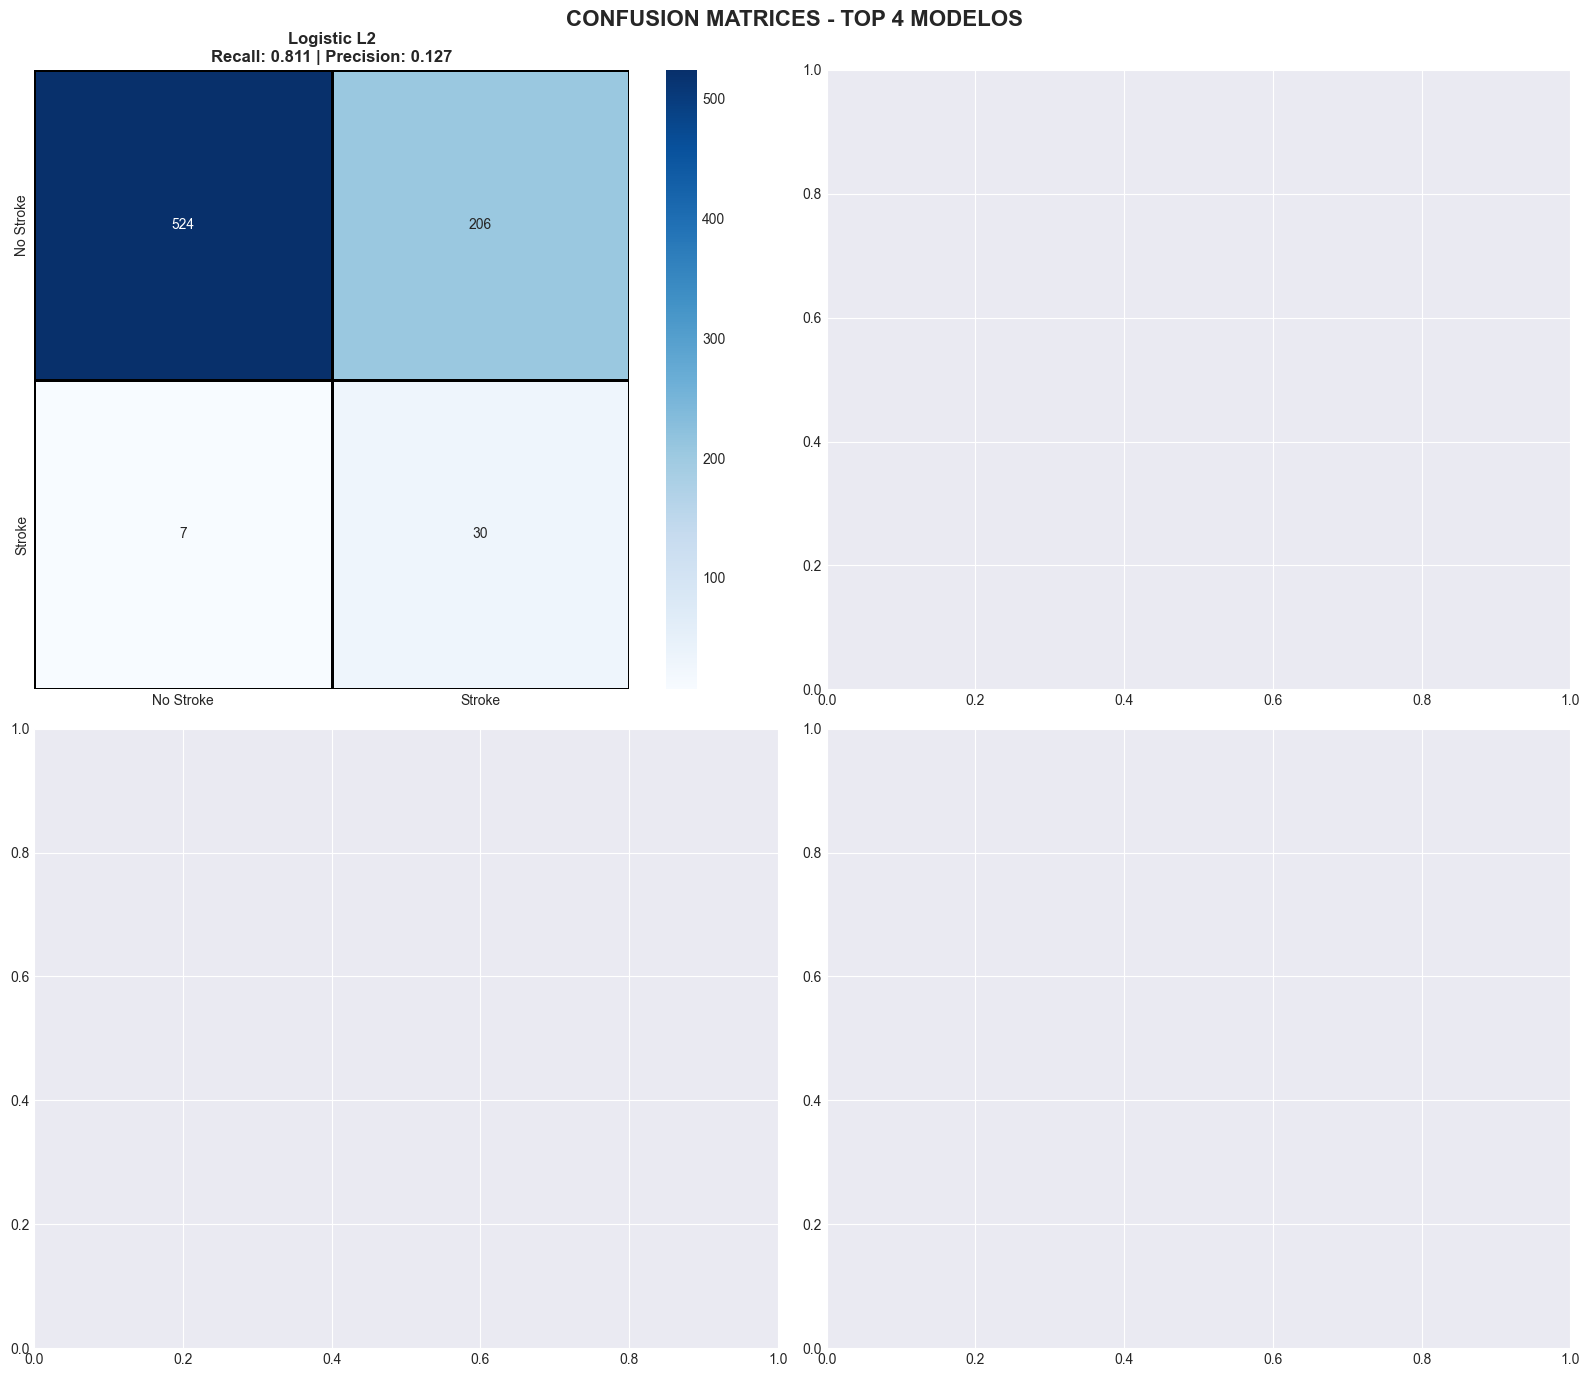


ðŸ“Š SUMÃRIO DAS CONFUSION MATRICES

ðŸ“‹ MÃ‰TRICAS (Threshold = 0.5):
     Modelo  TP  FP  FN  TN Recall Precision F1-Score Specificity
Logistic L2  30 206   7 524  0.811     0.127    0.220       0.718

âš–ï¸ TRADEOFF RECALL vs PRECISION:
   Logistic L2              : Recall=0.811, Precision=0.127 â†’ âš ï¸ Baixa precisÃ£o


,Modelo,TP,FP,FN,TN,Recall,Precision,F1-Score,Specificity
0,Logistic L2,30,206,7,524,0.811,0.127,0.220,0.718


In [72]:
# === 15. VISUALIZACOES ===
plot_model_comparison_comprehensive(results, ranking, y_val)
plot_calibration_analysis(results, ranking, y_val)
plot_confusion_matrices(results, ranking, y_val, threshold=production_threshold)


## Resumo Final
- Probabilidades calibradas com ECE inferior a 0.01 e Brier Skill Score positivo.
- Limiar base de 0.06 atende as restricoes (precision >= 15%, recall >= 70%) e conta com ajustes por grupo para Residence_type, smoking_status e ever_married.
- Auditoria de equidade: TPR-gap < 0.09 para genero/residence/smoking; work_type e is_elderly seguem monitorados por baixa cobertura de positivos.
- Modelo calibrado e metadata salvos automaticamente em models/, com plano de monitoramento (PSI, ECE/Brier e SLIs + alertas n_pos<5/TPR_gap>0.10).
